In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# torch

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

import os
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from PIL import Image


import torch.nn as nn
import torch.nn.functional as F

import gensim
import gensim.downloader

In [3]:
# warning off
import warnings
warnings.simplefilter('ignore')

# default font
plt.rcParams['font.size'] = 14

# default graph size
plt.rcParams['figure.figsize'] = (4,4)

# default graph grid
# plt.rcParams['axes.grid'] = True

# numpy precision
np.set_printoptions(suppress=True, precision=5)

# GPU

In [4]:
# device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preparation

In [5]:
# data_dir_path = './tiny-imagenet-200'
data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'

# data augmentation

def data_transform():
    return T.Compose([
        T.Resize(64),
        T.ColorJitter(brightness=0.5),
        T.RandomAffine(degrees=15, translate=(0.08,0.08), scale=(0.8,1.2), shear=10),
        T.RandomHorizontalFlip(),
        #T.RandomResizedCrop(64,scale=(0.7, 1.4)),
        T.ToTensor(),
    ])

# data formatting (only one time run at the beginning)
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    # os.system("rm -rf %s" % val_images_dir)
    #print("Cleaning up: %s" % val_images_dir)
    print("Formatting val done")
    
    
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train', transform=data_transform())
test_dataset = ImageFolder(data_dir_path + '/test', transform=T.ToTensor())

# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

print(len(d))

# TODO: replace with our trained model later
pretrain_wv = gensim.downloader.load('glove-wiki-gigaword-50')

aa = train_dataset.classes
for i in range(len(aa)):
    label_terms = d[aa[i]].split(', ')
    label_vector = torch.zeros(50)  # TODO: change to 500 (size of word vector) later
    num_terms = 0
    for term in label_terms:
        if term in pretrain_wv:
            label_vector += pretrain_wv[term]
            num_terms += 1
    if num_terms > 0:
        label_vector /= num_terms
    train_dataset.classes[i] = label_vector
    
def get_embeddings(labels):
    return torch.vstack([train_dataset.classes[i].to(device) for i in labels]).to(device)


82115


In [6]:
random_seed = 4
torch.manual_seed(random_seed);

val_size = 10000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(90000, 10000)

Label:  tensor([-0.2424, -0.5904,  0.5701, -0.6004, -0.2891,  0.3867,  0.1251,  0.4084,
         0.6628, -0.3609, -0.0527, -1.0556, -0.4151,  0.2962,  0.0984, -0.7136,
        -0.4373,  1.5181,  0.2778, -1.2450,  0.5242, -0.4382, -1.2863,  1.3718,
         0.9367, -0.3834, -0.7527, -0.4710,  0.2524,  0.3953, -0.2027,  0.4535,
         0.0091,  1.4661,  0.7554,  0.4844,  0.2677,  0.1090,  0.2168,  1.1247,
        -0.3577,  0.1931, -0.4777,  0.2089,  1.5511, -1.1474,  0.7982, -0.5341,
         0.9845, -0.4509]) (111)


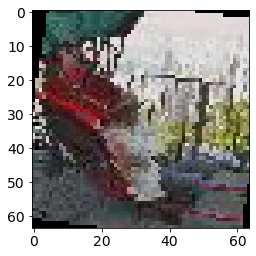

In [7]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*train_dataset[55555])

# def of common functions

## eval_loss loss calc

In [8]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs).to(device)
    
    #  損失計算
    get_embeddings(labels).to(device)
    loss = criterion(outputs, get_embeddings(labels).to(device), torch.ones(len(outputs)).to(device)).to(device)

    return loss

# Cosine loss for bimodal model. We actually want 1-similarity as 
# the similarity will be 0 when the vectors are orthogonal and close 
# to 1 when the same. 
def cosine_loss(vec1, vec2):
    vec1 = vec1.to(device)
    vec2 = vec1.to(device)
    return 1 - F.cosine_similarity(vec1, vec2)

## fit learning

In [9]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            get_embeddings(labels).to(device)
            loss = criterion(outputs, get_embeddings(labels).to(device), torch.ones(len(outputs)).to(device))
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            get_embeddings(labels).to(device)
            loss = criterion(outputs, get_embeddings(labels).to(device), torch.ones(len(outputs)).to(device))
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

## eval_history log analysis of learning

In [10]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

##  show_images_labels show image and label

In [11]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 20)

    if net is not None:
      # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

      # 予測計算
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(4, 5, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
            if label_name == predicted_name:
                c = 'green'
            else:
                c = 'blue'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [12]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## data prep

In [13]:
image1, label1 = train_dataset[0]
image2, label2 = train_dataset[1330]

print(image1.shape)
print(image2.shape)
print(label1)
print(label2)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
0
2


In [14]:
# DataLoader

# size of batch
batch_size = 100
# batch_size = 512

# DataLoarder of Training data
train_loader2 = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# DataLoarder of Test data
test_loader2 = DataLoader(val_ds,  batch_size=batch_size, shuffle=False) 

In [15]:
# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images2.shape)



torch.Size([100, 3, 64, 64])


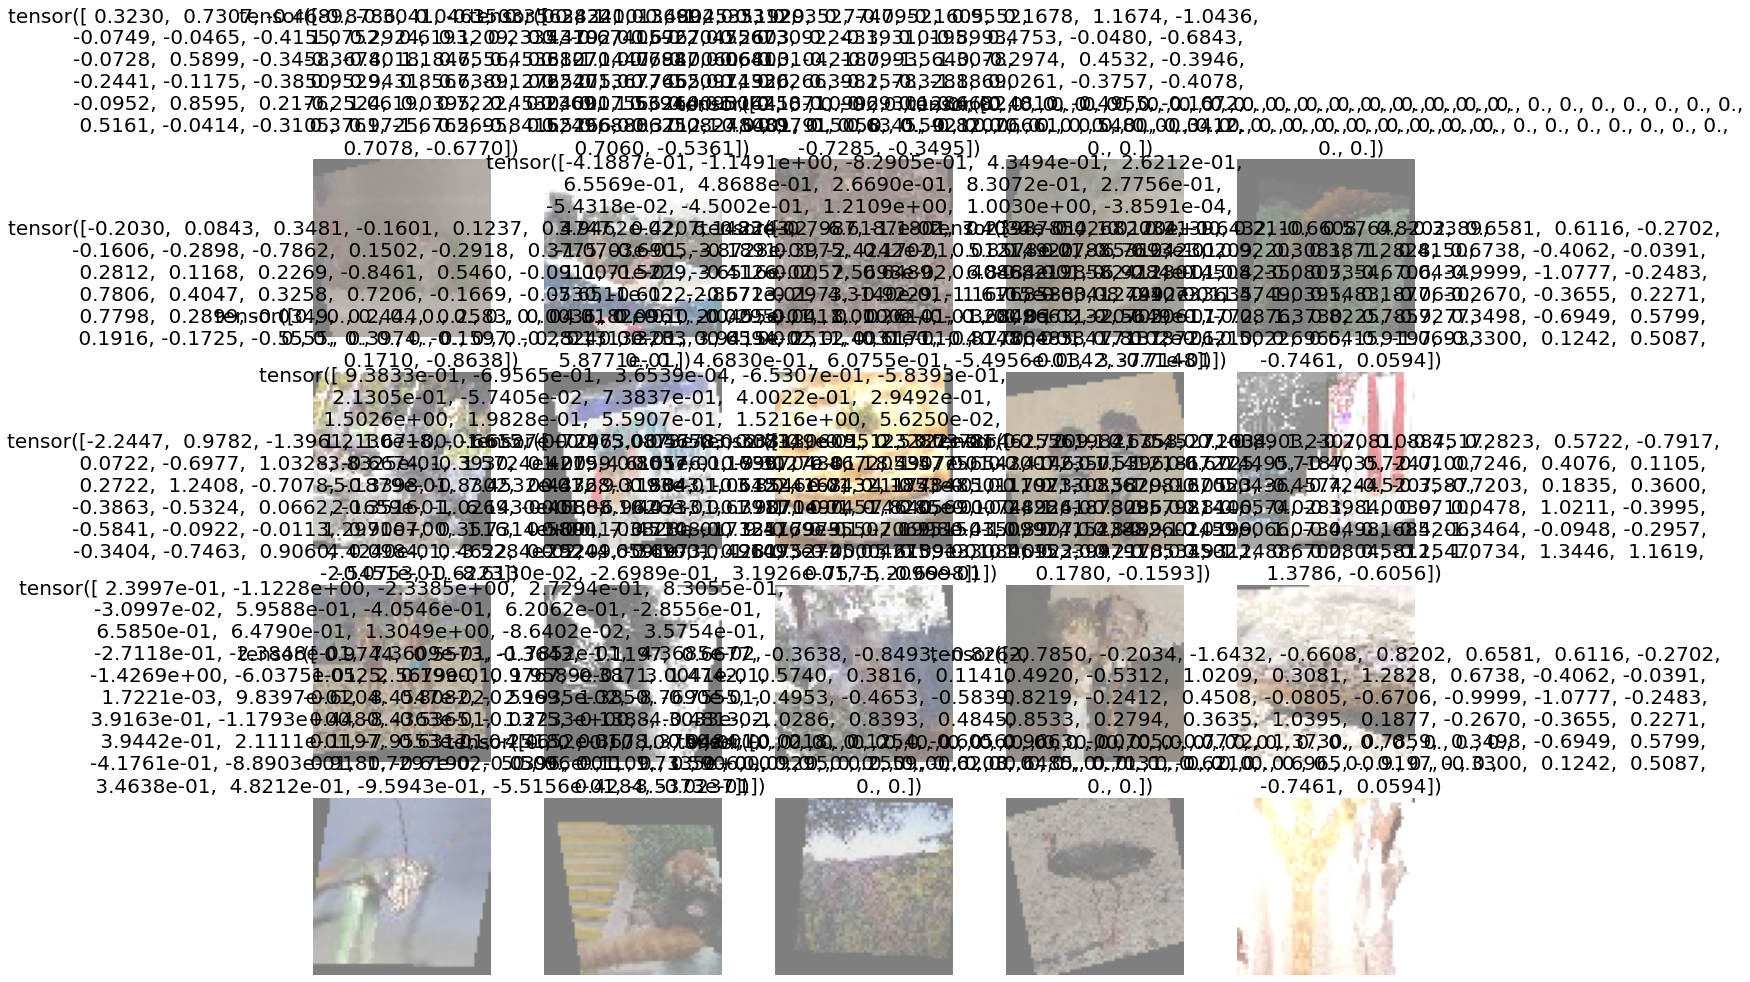

In [16]:
# 正解ラベル定義
classes = train_dataset.classes

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

# Def Model

### Parameters

In [17]:
# output degree: 出力次元数
# number of classes: 分類先クラス数
# n_output = len(classes)
n_output = 50  # TODO: change to 500 (size of word vector) later

# number of nodes of hidden layer 隠れ層のノード数
n_hidden = 256 

print(f'n_hidden: {n_hidden} n_output: {n_output}')



n_hidden: 256 n_output: 50


In [18]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_output)

        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.maxpool,          
            
            self.conv3,
            self.relu,
            self.maxpool,  
            
#             self.flatten,
#             self.l1,
#             self.relu,
#             self.l2,
            
#             nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 16, 32, 32

#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 16, 16, 16 

#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 32, 8, 8 


#             nn.Flatten(), # 16 x 2048
#             nn.Linear(2048, n_hidden),
#             nn.ReLU(),
#             nn.Linear(n_hidden, n_output),
#             self.conv1,# out: 16, 64, 64
#             self.relu,# out: 16, 64, 64
#             self.conv2,# out: 16, 64, 64
#             self.relu,# out: 16, 64, 64
#             self.maxpool # out: 16, 32, 32
        )

        self.classifier = nn.Sequential(
           self.l1,
           self.relu,
           self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Create model instance

In [19]:
# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# loss function: cross entropy 損失関数： 交差エントロピー関数
# criterion = nn.CrossEntropyLoss()
criterion = nn.CosineEmbeddingLoss().to(device)

# learning ratio: 学習率
lr = 0.01

# optimizer: gradient 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)



In [20]:
# summary of model: モデルの概要表示

print(net)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=2048, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=50, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=

In [21]:
# summary of model:モデルのサマリー表示

summary(net,(100,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 8, 8]           8,176
├─Conv2d: 1-2                            [100, 16, 64, 64]         1,216
├─ReLU: 1-3                              [100, 16, 64, 64]         --
├─MaxPool2d: 1-4                         [100, 16, 32, 32]         --
├─Conv2d: 1-5                            [100, 16, 32, 32]         2,320
├─ReLU: 1-6                              [100, 16, 32, 32]         --
├─MaxPool2d: 1-7                         [100, 16, 16, 16]         --
├─Conv2d: 1-8                            [100, 32, 16, 16]         4,640
├─ReLU: 1-9                              [100, 32, 16, 16]         --
├─MaxPool2d: 1-10                        [100, 32, 8, 8]           --
├─Flatten: 1-11                          [100, 2048]               --
├─Sequential: 1-12                       [100, 50]                 537,39

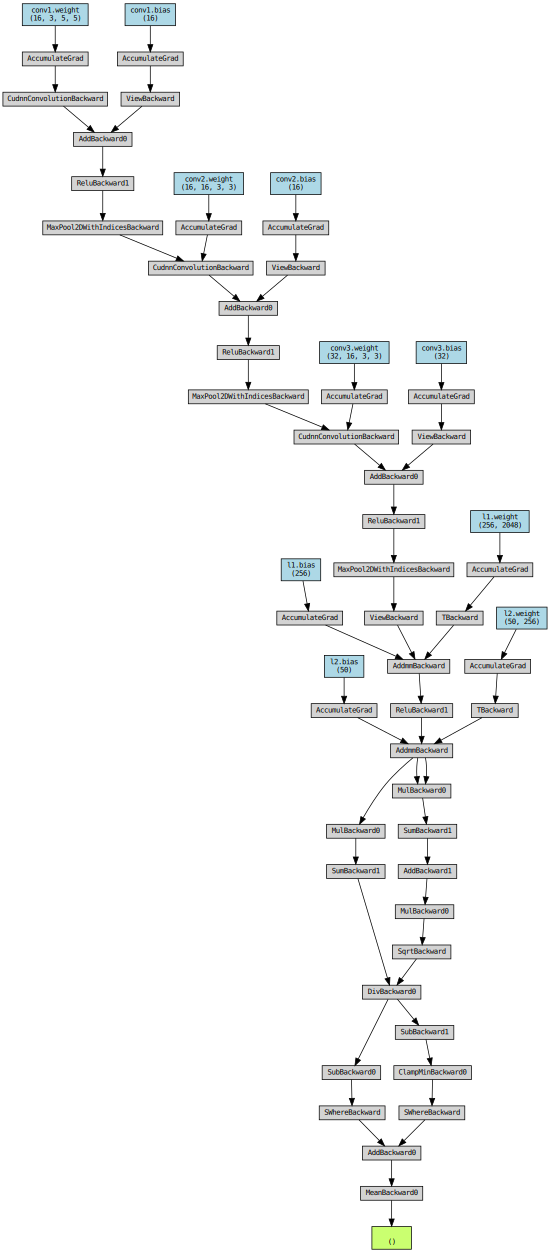

In [22]:
# calc loss: 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# visualize calc loss: 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)



In [23]:
# init randam, 乱数初期化
torch_seed()

# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# loss function: cross entropy損失関数： 交差エントロピー関数
# criterion = nn.CrossEntropyLoss()
criterion = nn.CosineEmbeddingLoss()

# learning step 学習率
lr = 0.01

# optimizser 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# epock 繰り返し回数
num_epochs = 70

# output 評価結果記録用
history2 = np.zeros((0,5))

# learning: 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)



  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [1/70], loss: 0.00723 acc: 0.00497 val_loss: 0.00715, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [2/70], loss: 0.00713 acc: 0.00502 val_loss: 0.00707, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [3/70], loss: 0.00708 acc: 0.00528 val_loss: 0.00704, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [4/70], loss: 0.00706 acc: 0.00528 val_loss: 0.00703, val_acc: 0.00590


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [5/70], loss: 0.00704 acc: 0.00564 val_loss: 0.00700, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [6/70], loss: 0.00702 acc: 0.00579 val_loss: 0.00699, val_acc: 0.00670


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [7/70], loss: 0.00700 acc: 0.00621 val_loss: 0.00698, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [8/70], loss: 0.00698 acc: 0.00603 val_loss: 0.00695, val_acc: 0.00640


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [9/70], loss: 0.00696 acc: 0.00604 val_loss: 0.00695, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [10/70], loss: 0.00695 acc: 0.00637 val_loss: 0.00692, val_acc: 0.00660


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [11/70], loss: 0.00693 acc: 0.00629 val_loss: 0.00691, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [12/70], loss: 0.00692 acc: 0.00632 val_loss: 0.00690, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [13/70], loss: 0.00691 acc: 0.00616 val_loss: 0.00689, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [14/70], loss: 0.00690 acc: 0.00593 val_loss: 0.00688, val_acc: 0.00580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [15/70], loss: 0.00690 acc: 0.00610 val_loss: 0.00688, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [16/70], loss: 0.00689 acc: 0.00611 val_loss: 0.00687, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [17/70], loss: 0.00688 acc: 0.00592 val_loss: 0.00686, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [18/70], loss: 0.00687 acc: 0.00589 val_loss: 0.00685, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [19/70], loss: 0.00687 acc: 0.00610 val_loss: 0.00685, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [20/70], loss: 0.00686 acc: 0.00599 val_loss: 0.00686, val_acc: 0.00670


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [21/70], loss: 0.00686 acc: 0.00583 val_loss: 0.00684, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [22/70], loss: 0.00685 acc: 0.00596 val_loss: 0.00683, val_acc: 0.00520


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [23/70], loss: 0.00684 acc: 0.00594 val_loss: 0.00684, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [24/70], loss: 0.00684 acc: 0.00580 val_loss: 0.00682, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [25/70], loss: 0.00683 acc: 0.00579 val_loss: 0.00682, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [26/70], loss: 0.00683 acc: 0.00574 val_loss: 0.00681, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [27/70], loss: 0.00682 acc: 0.00602 val_loss: 0.00681, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [28/70], loss: 0.00682 acc: 0.00592 val_loss: 0.00683, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [29/70], loss: 0.00681 acc: 0.00566 val_loss: 0.00679, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [30/70], loss: 0.00680 acc: 0.00567 val_loss: 0.00679, val_acc: 0.00600


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [31/70], loss: 0.00680 acc: 0.00550 val_loss: 0.00681, val_acc: 0.00590


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [32/70], loss: 0.00679 acc: 0.00596 val_loss: 0.00677, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [33/70], loss: 0.00679 acc: 0.00577 val_loss: 0.00677, val_acc: 0.00580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [34/70], loss: 0.00679 acc: 0.00578 val_loss: 0.00676, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [35/70], loss: 0.00678 acc: 0.00592 val_loss: 0.00676, val_acc: 0.00530


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [36/70], loss: 0.00677 acc: 0.00608 val_loss: 0.00677, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [37/70], loss: 0.00677 acc: 0.00589 val_loss: 0.00676, val_acc: 0.00580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [38/70], loss: 0.00676 acc: 0.00593 val_loss: 0.00675, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [39/70], loss: 0.00676 acc: 0.00584 val_loss: 0.00675, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [40/70], loss: 0.00675 acc: 0.00593 val_loss: 0.00673, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [41/70], loss: 0.00675 acc: 0.00603 val_loss: 0.00674, val_acc: 0.00580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [42/70], loss: 0.00674 acc: 0.00608 val_loss: 0.00674, val_acc: 0.00490


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [43/70], loss: 0.00674 acc: 0.00588 val_loss: 0.00674, val_acc: 0.00530


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [44/70], loss: 0.00673 acc: 0.00584 val_loss: 0.00672, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [45/70], loss: 0.00673 acc: 0.00577 val_loss: 0.00672, val_acc: 0.00590


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [46/70], loss: 0.00672 acc: 0.00602 val_loss: 0.00672, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [47/70], loss: 0.00672 acc: 0.00598 val_loss: 0.00671, val_acc: 0.00580


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [48/70], loss: 0.00671 acc: 0.00588 val_loss: 0.00671, val_acc: 0.00620


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [49/70], loss: 0.00671 acc: 0.00608 val_loss: 0.00671, val_acc: 0.00550


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [50/70], loss: 0.00671 acc: 0.00586 val_loss: 0.00670, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [51/70], loss: 0.00670 acc: 0.00590 val_loss: 0.00670, val_acc: 0.00640


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [52/70], loss: 0.00670 acc: 0.00601 val_loss: 0.00670, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [53/70], loss: 0.00669 acc: 0.00646 val_loss: 0.00673, val_acc: 0.00640


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [54/70], loss: 0.00669 acc: 0.00606 val_loss: 0.00668, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [55/70], loss: 0.00669 acc: 0.00586 val_loss: 0.00670, val_acc: 0.00530


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [56/70], loss: 0.00668 acc: 0.00580 val_loss: 0.00671, val_acc: 0.00640


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [57/70], loss: 0.00668 acc: 0.00601 val_loss: 0.00669, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [58/70], loss: 0.00667 acc: 0.00590 val_loss: 0.00667, val_acc: 0.00550


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [59/70], loss: 0.00667 acc: 0.00604 val_loss: 0.00666, val_acc: 0.00540


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [60/70], loss: 0.00666 acc: 0.00602 val_loss: 0.00668, val_acc: 0.00530


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [61/70], loss: 0.00666 acc: 0.00587 val_loss: 0.00666, val_acc: 0.00560


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [62/70], loss: 0.00665 acc: 0.00611 val_loss: 0.00667, val_acc: 0.00540


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [63/70], loss: 0.00665 acc: 0.00611 val_loss: 0.00666, val_acc: 0.00610


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [64/70], loss: 0.00665 acc: 0.00587 val_loss: 0.00665, val_acc: 0.00630


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [65/70], loss: 0.00664 acc: 0.00620 val_loss: 0.00665, val_acc: 0.00540


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [66/70], loss: 0.00664 acc: 0.00576 val_loss: 0.00665, val_acc: 0.00520


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [67/70], loss: 0.00664 acc: 0.00603 val_loss: 0.00663, val_acc: 0.00570


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [68/70], loss: 0.00663 acc: 0.00599 val_loss: 0.00665, val_acc: 0.00510


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [69/70], loss: 0.00663 acc: 0.00626 val_loss: 0.00663, val_acc: 0.00530


  0%|          | 0/900 [00:00<?, ?it/s]

Epoch [70/70], loss: 0.00662 acc: 0.00619 val_loss: 0.00663, val_acc: 0.00440


Initial: loss: 0.00715 accuracy: 0.00560
Final: loss: 0.00663 accuracy: 0.00440


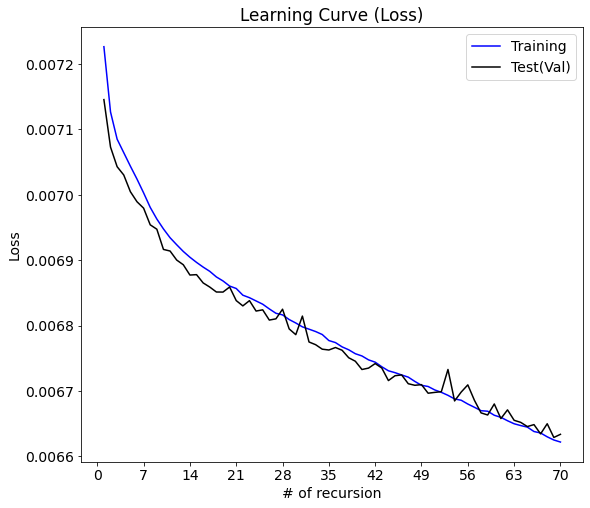

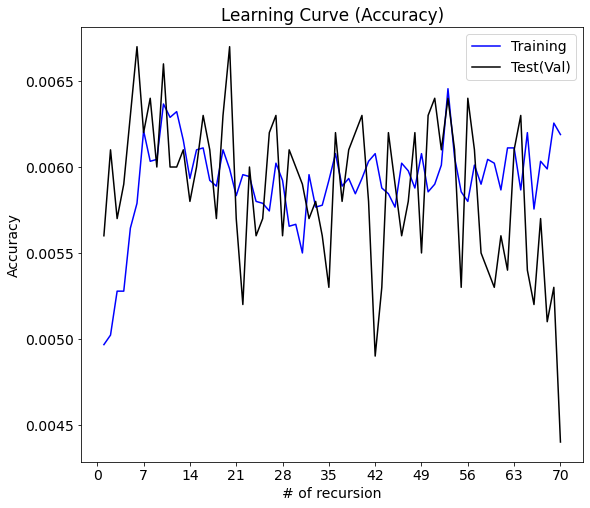

In [24]:
# 評価

evaluate_history(history2)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

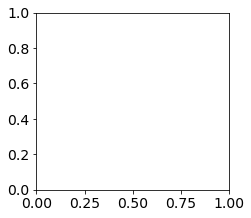

In [25]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)

